## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from astropy import constants as const
from astropy import units as u
from matplotlib.ticker import FuncFormatter
from astropy.cosmology import Planck18 as cosmo
from scipy.integrate import quad
from scipy.optimize import minimize
from astropy.cosmology import Planck18 as cosm
from scipy.optimize import differential_evolution

## Data

In [3]:
# ================================
# Constants and Observational Data
# ================================
h = const.h.cgs.value           # Planck's constant (erg s)
k_B = const.k_B.cgs.value       # Boltzmann constant (erg/K)
c = const.c.cgs.value           # Speed of light (cm/s)
beta_CII = 2.03                 # Fixed dust emissivity index
L_CII = 6.1e8 /9.3              # L_CII in Solar Luminosity, 9.3 = magnification constant (vet ej ifall L_CII redan är intrinsic?? tror ej det)
nu_0 = 1900e9                   # Reference frequency in Hz
kappa_0 = 10.41                 # Dust mass absorption coefficient at nu_0 in cm^2/g
Z_fid = 1
L_CII_solar = 6.1e8 #/ 9.3  # Convert to L_sun
L_CII_erg = L_CII_solar * const.L_sun.cgs.value  # Convert to erg/s
# Redshift of A1689-zD1
z = 7.13
T_CMB_z = 2.73 * (1 + z)        # CMB temperature at redshift z
magnification_factor = 1        # Magnification factor (already accounted for in the paper)
D_L = cosmo.luminosity_distance(z).to(u.cm)  # Convert to cm   

# Observational ALMA flux densities
data = np.array([
    [0.427, 154, 37],  # Band 9
    [0.728, 180, 39],  # Band 8
    [0.873, 143, 15],  # Band 7
    [1.33, 60, 11],    # Band 6
])

# Convert observed values to appropriate units
wavelength_obs = data[:, 0] * u.mm
freq_obs = (const.c.to(u.m / u.s) / wavelength_obs).to(u.Hz).value  # Observed Frequency in Hz

flux_obs = data[:, 1] * 1e-6 * u.Jy  # Convert µJy to Jy
flux_err = data[:, 2] * 1e-6 * u.Jy  # Convert µJy to Jy

# band 6 intrinsic flux 
flux_158_jy = 60e-6  # 60 µJy → Jy
flux_158_jy_err = 11e-6  # 11 µJy → Jy

# Dbserved flux at 158 µm (rest-frame)
lambda_158_rest = 158 * 1e-6 * u.m  # Convert µm to meters
lambda_158_rest = lambda_158_rest.to(u.cm).value  # Convert meters to cm


In [4]:
# ================================
# Model Definitions
# ================================

def GDR_function(Z):
    """ Compute gas-to-dust ratio (GDR) following the empirical relation. """
    Z = np.clip(Z, 0.2, 1.0)  # Ensure valid metallicities
    GDR = 162 * (1 / Z)  # Empirical scaling from local universe
    return np.clip(GDR, 30, 150)  # Keep within a reasonable range

def sfr_from_CII(L_CII):
    """
    Compute SFR from [CII] luminosity using the high-redshift calibration 
    from De Looze et al. (2014). 
    """
    log_SFR = -8.52 + 1.18 * np.log10(L_CII)
    SFR = 10 ** log_SFR  # Convert log SFR to linear SFR in M_sun/yr
    return SFR

def integrand(nu, T_dust, beta):
    """
    Integrand for computing the IR luminosity (modified blackbody).
    """
    return modified_blackbody(nu, T_dust, beta)

def compute_L_IR(T_dust, beta, M_dust):
    """
    Compute total IR luminosity (L_IR) by integrating the dust emission from 8 to 1000 µm.
    """
    # Convert wavelength limits (8-1000 µm) to frequency (Hz)
    lambda_min = 8e-4  # centimeters
    lambda_max = 1000e-4  # centimeters
    nu_min = c / lambda_max 
    nu_max = c / lambda_min
    
    # Integrate the modified blackbody over the IR range
    L_IR_integral, _ = quad(integrand, nu_min, nu_max, args=(T_dust, beta))

    # Convert M_dust to grams
    M_dust_cgs = M_dust * const.M_sun.cgs.value  # M_dust in grams

    # Multiply by dust mass to get total IR luminosity
    L_IR = M_dust_cgs * L_IR_integral  # L_IR in erg/s

    # Convert erg/s to solar luminosities (L_sun)
    L_IR_solar = L_IR / const.L_sun.cgs.value
    #print(f'L_IR_solar : {L_IR_solar}')
    return L_IR_solar

def compute_L_FIR(T_dust, beta, M_dust):
    """
    Compute far-infrared luminosity (L_FIR) by integrating the dust emission from 42.5 to 122.5 µm.
    """
    # Convert wavelength limits (42.5-122.5 µm) to frequency (Hz)
    lambda_min = 42.5e-4  # centimeters
    lambda_max = 122.5e-4  # centimeters
    nu_min = c / lambda_max
    nu_max = c / lambda_min
    
    # Integrate the modified blackbody over the FIR range
    L_FIR_integral, _ = quad(integrand, nu_min, nu_max, args=(T_dust, beta))

    # Convert M_dust to grams
    M_dust_cgs = M_dust * const.M_sun.cgs.value  # M_dust in grams

    # Multiply by dust mass to get total FIR luminosity
    L_FIR = M_dust_cgs * L_FIR_integral  # L_FIR in erg/s

    # Convert erg/s to solar luminosities (L_sun)
    L_FIR_solar = L_FIR / const.L_sun.cgs.value
    return L_FIR_solar

def sfr_from_dust(L_IR):
    """
    Compute SFR from dust-obscured IR luminosity using Kennicutt (1998).
    Constant taken from Bakx et al 2021
    """
    #print(f'L_FIR : {L_IR}')
    return 1.73e-10 * L_IR  # SFR in M_sun/yr

def dust_obscured_sfr_constraint(Td_corrected, M_dust, L_CII):
    """
    Apply the constraint that SFR_FIR <= total measured SFR.
    """
    L_FIR = compute_L_FIR(Td_corrected, beta_CII, M_dust)  # Compute FIR luminosity
    SFR_FIR = 1e-10 * L_FIR  # Convert to SFR using Eq. (16)
    SFR_CII = sfr_from_CII(L_CII)  # Compute total SFR from CII

    return SFR_FIR <= SFR_CII  # Ensure constraint is met

def max_dust_mass_constraint(M_dust, M_star, Z):
    """ Apply the dust mass constraint from SN production (Eq. 15 from the paper). """
    y_Z = 2  # Metal yield in M_sun per SN (upper limit)
    v_SN = 1 / 53  # SNe per M_sun of formed stars (Salpeter IMF)
    
    M_dust_max_SN = y_Z * v_SN * M_star  # Maximum dust mass from SN production
    
    return M_dust <= M_dust_max_SN

def calculate_alpha_CII(kappa_s, extension_factor, L_CII_solar):
    """
    Compute α_CII using the high-z correction from Sommovigo et al. (2021).
    
    Parameters:
    - kappa_s: Burstiness parameter (1-50)
    - extension_factor: y = r_CII / r_* (1.5 - 3.0)
    - L_CII_solar: [CII] luminosity in L_sun

    Returns:
    - α_CII (M_sun / L_sun)
    """
    # Compute SFR using the De Looze relation
    SFR = sfr_from_CII(L_CII_solar)  # Returns SFR in M_sun/yr

    # Compute Σ_SFR using the high-z correction from Eq. (6)
    Sigma_CII = L_CII_solar / (np.pi * (extension_factor * 0.5)**2)  # L_sun/kpc^2
    Sigma_SFR = 10**(-7.06) * (extension_factor**2) * Sigma_CII  # M_sun/yr/kpc^2

    # Compute α_CII using the high-z formula from Eq. (7)
    alpha_CII_hz = (32.47 / (kappa_s ** (5/7))) * (extension_factor ** 2) * (Sigma_SFR ** -0.29)

    print(f'alpha_CII_hz: {alpha_CII_hz}')
    return alpha_CII_hz

def planck(nu, T):
    exponent = h * nu / (k_B * T)

    # Use np.where() to handle arrays
    exponent_safe = np.where(exponent > 500, 500, exponent)  # Cap exponent at 500
    planck_value = (2.0 * h * nu**3 / c**2) / (np.exp(exponent_safe) - 1.0)
    #print(f"Planck(nu={nu}, T={T}): {planck_value}")
    return planck_value   

def modified_blackbody(nu, T_dust, beta):
    B_nu = planck(nu, T_dust)  # erg/s/cm^2/Hz/sr
    kappa_nu = kappa_0 * (nu / nu_0) ** beta
    return 4 * np.pi * B_nu * kappa_nu  # Multiply by 4π to convert to luminosity

def cmb_corrected_temperature(T_dust_observed, beta, z):
    """Applies the da Cunha et al. (2013) correction for CMB heating."""
    T_CMB_0 = 2.7255   # 2.7255 K (Fixsen 2009).
    T_CMB_z = T_CMB_0 * (1 + z)  # CMB temperature at redshift z
    
    # Apply CMB heating correction
    T_dust_corrected = (T_dust_observed**(4 + beta) + T_CMB_0**(4 + beta) * ((1 + z)**(4 + beta) - 1))**(1 / (4 + beta))

    return T_dust_corrected

def cmb_corrected_temperature_simplified(T_dust_observed, beta, z):
    """
    Simplified CMB correction for dust temperature based on da Cunha et al. (2013).
    only accounts for the extra heating due to the CMB at redshift z
    not the baseline CMB present today.

    Returns:
    - Corrected dust temperature accounting for CMB heating (in K).
    """
    T_CMB_0 = 2.7255   # Present-day CMB temperature in K
    T_CMB_z = T_CMB_0 * (1 + z)  # CMB temperature at redshift z

    # Simplified correction formula
    T_dust_corrected = (T_dust_observed**(4 + beta) + T_CMB_z**(4 + beta) - T_CMB_0**(4 + beta))**(1 / (4 + beta))

    return T_dust_corrected


def observed_flux(nu_obs, T_dust, beta, M_dust, d_L):
    """
    Compute observed flux at frequency nu_obs, output in Jy.

    Parameters:
    - nu_obs: Observed frequency (Hz)
    - T_dust: Dust temperature (K)
    - beta: Dust emissivity index
    - M_dust: Dust mass (M_sun)
    - d_L: Luminosity distance (cm)

    Returns:
    - Flux density in Jy
    """
    nu_rest = nu_obs * (1 + z)  # Shift to rest-frame frequency
    M_dust_cgs = M_dust * const.M_sun.cgs.value  # Convert dust mass to grams
    d_L = d_L.to('cm').value if hasattr(d_L, 'unit') else d_L  # Ensure d_L is in cm

    T_dust_corr = cmb_corrected_temperature(T_dust, beta, z)

    # Blackbody emission from dust and CMB at rest-frame frequency
    B_nu_dust = planck(nu_rest, T_dust_corr)  #B_nu_dust = planck(nu_rest, T_dust)
    B_nu_CMB = planck(nu_rest, 2.7255 * (1 + z))

    # Dust opacity at rest-frame frequency
    kappa_nu = kappa_0 * (nu_rest / nu_0) ** beta

    # Observed flux density (erg/s/cm^2/Hz)
    flux_density_erg = ((1 + z) / (d_L**2)) * M_dust_cgs * kappa_nu * (B_nu_dust - B_nu_CMB)

    # Convert from erg/s/cm²/Hz to Jy
    flux_density_Jy = flux_density_erg / 1e-23

    return flux_density_Jy

def intrinsic_flux(nu_obs, T_dust, beta, M_dust, d_L):
    nu_rest = nu_obs * (1 + z)
    M_dust_cgs = M_dust * const.M_sun.cgs.value
    d_L = d_L.to('cm').value if hasattr(d_L, 'unit') else d_L
    
    # Only the dust emission without subtracting the CMB background
    B_nu_dust = planck(nu_rest, T_dust)
    kappa_nu = kappa_0 * (nu_rest / nu_0) ** beta
    
    flux_density_erg = ((1 + z) / (d_L**2)) * M_dust_cgs * kappa_nu * B_nu_dust
    flux_density_uJy = flux_density_erg / 1e-23 # Convert to Jy
    
    return flux_density_uJy

def observed_flux_CII(nu_obs, T_dust_CII, M_dust, d_L):
    """
    Compute observed flux at frequency nu_obs using the [CII]-based method, looping over M_dust.
    """
    nu_rest = nu_obs * (1 + z)
    kappa_nu = kappa_0 * (nu_rest / nu_0) ** beta_CII

    T_dust_corr = cmb_corrected_temperature(T_dust_CII, beta_CII, z)

    B_nu_dust = planck(nu_rest, T_dust_corr)
    B_nu_CMB = planck(nu_rest, 2.7255 * (1 + z))

    M_dust_cgs = M_dust * const.M_sun.cgs.value  # Convert dust mass to grams

    # Compute flux based only on M_dust
    F_nu = ((1 + z) / (d_L**2)) * M_dust_cgs * kappa_nu * (B_nu_dust - B_nu_CMB)
    
    # Convert from erg/s/cm²/Hz to Jy
    return F_nu / 1e-23

# Function to minimize (solving for T_dust)
def flux_equation_CII(Td_CII, M_dust, flux_obs):
    """
    Solve for T_dust using the [CII]-based equation.
    """
    nu_obs_158 = c / (lambda_158_rest * (1 + z))  # Observed frequency for 158 µm
    flux_model = observed_flux_CII(nu_obs_158, Td_CII, M_dust, D_L).value

    # DEBUG: Print units before subtraction
    #print(f"flux_model: {flux_model}, unit: {getattr(flux_model, 'unit', 'No Unit')}")
    #print(f"flux_obs: {flux_obs}, unit: {getattr(flux_obs, 'unit', 'No Unit')}") 

    return flux_model - flux_obs # Convert to unitless for optimization


In [5]:
# ================================
# Likelihood and Prior Functions
# ================================
def log_likelihood(params, freq_obs, flux_obs, flux_err, z):
    """Computes the log-likelihood for MCMC fitting."""
    T_dust, beta, M_dust = params
    model_flux = observed_flux(freq_obs, T_dust, beta, M_dust, D_L)
    residuals = (flux_obs - model_flux) / flux_err
    return -0.5 * np.sum(residuals**2)

def log_prior(params):
    """Defines the prior distribution for MCMC fitting."""
    T_dust, beta, M_dust = params
    if 25 < T_dust < 80 and 0.2 < beta < 2.5 and 1e6 < M_dust < 1e12:
        return 0.0
    return -np.inf

def log_probability(params, freq_obs, flux_obs, flux_err, z):
    """Computes the log-probability for MCMC fitting."""
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, freq_obs, flux_obs, flux_err, z)

In [6]:
# ================================
# MCMC Setup and Execution
# ================================
n_walkers = 64
n_steps = 10000
pos = [np.random.uniform([30, 0.5, 1e6], [60, 2.5, 1e7]) for _ in range(n_walkers)]

sampler = emcee.EnsembleSampler(n_walkers, 3, log_probability, args=(freq_obs, flux_obs.value, flux_err.value, z))
print("Running MCMC...")
sampler.run_mcmc(pos, n_steps, progress=True)
print("MCMC complete!")

# Extract MCMC results
flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)
T_dust_mcmc, beta_mcmc, M_dust_mcmc = np.median(flat_samples, axis=0)

# Compute confidence intervals
# [2.5, 97.5] = 3sigma,  [16, 84] = 1sigma 
T_dust_err = np.percentile(flat_samples[:, 0], [16, 84])
beta_err = np.percentile(flat_samples[:, 1], [16, 84])
M_dust_err_corr = np.percentile(flat_samples[:, 2], [16, 84]) / magnification_factor
M_dust_mcmc_corr =  M_dust_mcmc #/ magnification_factor


Running MCMC...


100%|██████████| 10000/10000 [01:12<00:00, 138.88it/s]

MCMC complete!


In [7]:
# ================================
# SED Plotting Setup
# ================================
sorted_indices = np.argsort(wavelength_obs)
wavelength_obs = wavelength_obs[sorted_indices]
freq_obs = freq_obs[sorted_indices]
flux_obs = flux_obs[sorted_indices]
flux_err = flux_err[sorted_indices]

# Generate rest-frame wavelength and frequency grid
wavelength_rest = wavelength_obs / (1 + z)
freq_plot = np.logspace(np.log10(min(freq_obs)) - 0.5, np.log10(max(freq_obs)) + 0.5, 200)

wavelength_plot = (const.c.to(u.um / u.s).value / freq_plot) / (1 + z)

#T_dust_mcmc_corrected = cmb_corrected_temperature(T_dust_mcmc, beta_mcmc, z)
# Compute best-fit SED
model_flux_plot = observed_flux(freq_plot, T_dust_mcmc, beta_mcmc, M_dust_mcmc, D_L) * 1e6

# Compute confidence intervals
n_samples = 7000
random_samples = flat_samples[np.random.randint(len(flat_samples), size=n_samples)]
flux_samples = np.array([observed_flux(freq_plot, s[0], s[1], s[2],  D_L) * 1e6 for s in random_samples])
flux_lower, flux_upper = np.percentile(flux_samples, [16, 84], axis=0)
#####################################################################################################################################################################


In [8]:
# ================================
# [CII]-Based Spectrum Calculation
# ------------------------------------#

# Star formation timescale (300 Myr)
t_SF = 2.5e8  # in years
SFR_CII = sfr_from_CII(L_CII_solar)

gdr_val = GDR_function(Z_fid)

M_star_initial = SFR_CII * t_SF # Estimated stellar mass

# ------------------------------------------------------------
# SOLVE FOR T_d TO MATCH 158um FLUX
# ------------------------------------------------------------

def flux_equation(Td, M_dust, flux_obs):
    nu_obs_158 = c / (lambda_158_rest * (1 + z))  # Corrected for redshift
    flux_model = observed_flux(nu_obs_158, Td, beta_CII, M_dust, D_L)
    return flux_model - flux_obs

T_guess = 43     # initial guess

# Monte Carlo Sampling for Confidence Interval (CII-Based)
n_samples_CII = 6000  # Number of MC samples

# Sample uncertainties
log_mean = np.log(flux_158_jy)  # Convert mean to log space
log_std = flux_158_jy_err / flux_158_jy  # Convert standard deviation to log space
flux_158_samples = np.random.lognormal(log_mean, log_std, n_samples_CII)

Z_samples = np.random.uniform(0.2, 1, n_samples_CII) 
extension_factors = np.random.uniform(1.5, 3.0, n_samples_CII)
kappa_s_samples = np.random.uniform(1, 50, n_samples_CII)  # Sample κs
GDR_samples = GDR_function(Z_samples)  # Avoid extreme GDR values

# Calculate α_CII dynamically based on sampled parameters
alpha_CII_samples = np.array([calculate_alpha_CII(kappa_s, ext, L_CII_solar) 
                              for kappa_s, ext in zip(kappa_s_samples, extension_factors)])
print(f"Sampled α_CII values: {alpha_CII_samples[:10]}")

# Compute M_dust for each sample
M_dust_samples = (alpha_CII_samples * L_CII_solar) / GDR_samples

# Initialize arrays to store valid samples that meet the SFR constraint
valid_Td_CII_samples = []
valid_M_dust_samples = []

print(f"Flux 158 Sample: min={np.min(flux_158_samples)}, max={np.max(flux_158_samples)}")
print(f"Dust Mass Sample: min={np.min(M_dust_samples)}, max={np.max(M_dust_samples)}")

# Loop through each Monte Carlo sample and apply both constraints
for flux_158, M_dust, Z in zip(flux_158_samples, M_dust_samples, Z_samples):
    perturbation = np.random.uniform(-4, 4)  # Broaden perturbation range
    T_initial = 40 + perturbation  # Initial guess
    
    result = differential_evolution(lambda T: abs(flux_equation_CII(T, M_dust, flux_158)), bounds=[(30, 80)])

    if result.success:
        Td_solution = result.x[0]
        
        # Apply constraints
        if dust_obscured_sfr_constraint(Td_solution, M_dust, L_CII_solar) and max_dust_mass_constraint(M_dust, M_star_initial, Z):
            valid_Td_CII_samples.append(Td_solution)
            valid_M_dust_samples.append(M_dust)
        else:
            print(f"Filtered out: Td={Td_solution}, M_dust={M_dust}, Z={Z}")
    else:
        print(f"Optimization failed for M_dust={M_dust}")

# Convert to numpy arrays for analysis
valid_Td_CII_samples = np.array(valid_Td_CII_samples)
valid_M_dust_samples = np.array(valid_M_dust_samples)

# Check how many samples passed the SFR constraint
print(f"Valid samples after applying SFR constraint: {len(valid_Td_CII_samples)} out of {n_samples_CII}")

# Compute 1σ confidence interval
Td_CII_err = np.percentile(valid_Td_CII_samples, [16, 84])
Md_CII_err = np.percentile(valid_M_dust_samples, [16, 84])

# Extract lower and upper bounds
Td_CII_lower_corrected, Td_CII_upper_corrected = Td_CII_err
Md_CII_lower, Md_CII_upper = Md_CII_err

# Use median of valid samples
Td_median_corrected = np.median(valid_Td_CII_samples)
Md_median = np.median(valid_M_dust_samples)


# Compute the flux for each sampled Td_CII and M_dust using observed_flux
flux_CII_samples = np.array([
    [observed_flux_CII(nu, Td, M_dust, D_L).value * 1e6 for nu in freq_plot]  
    for Td, M_dust in zip(valid_Td_CII_samples, valid_M_dust_samples)
    
])

# Compute 16th and 84th percentile flux values (1σ confidence interval)
flux_CII_lower, flux_CII_upper = np.percentile(flux_CII_samples, [16, 84], axis=0) #* 0.1

# Frequency for 158 µm in the rest-frame
nu_158_rest = c / (158e-4 * (1 + z))  # Convert 158 µm to frequency in Hz

# Calculate flux at 158 µm using the CII-based method
flux_CII_at_158 = observed_flux(nu_158_rest, Td_median_corrected, beta_CII, Md_median, D_L) * 1e6  # Convert to µJy

print(f"Observed Flux at 158 µm (Band 6): {flux_158_jy * 1e6:.2f} µJy")
print(f"Calculated Flux from CII-based method at 158 µm: {flux_CII_at_158:.2f} µJy")

print(f'Td_median_corrected (before CMB) : {Td_median_corrected}')
# Apply CMB correction to median dust temperature
#Td_median_corrected = cmb_corrected_temperature_simplified(Td_median_corrected, beta_CII, z)
# Step 1: Compute IR Luminosity using the median values
L_IR = compute_L_IR(Td_median_corrected, beta_CII, Md_median)
# Step 2: Convert L_IR to SFR
SFR_dust = sfr_from_dust(L_IR)
print(f"Total IR Luminosity (L_IR) = {L_IR:.2e} L_sun")
print(f'Estimated stellar mass = {M_star_initial}')
print(f'SFR from CII = {SFR_CII}')
print(f"Star Formation Rate from Dust = {SFR_dust:.2f} M_sun/yr")

# Print MCMC results
print("MCMC Results:") 
print(f"T_dust (CMB corr.)= {T_dust_mcmc:.2f} (+{T_dust_err[1] - T_dust_mcmc:.2f}, -{T_dust_mcmc - T_dust_err[0]:.2f}) K")
print(f"Beta = {beta_mcmc:.2f} (+{beta_err[1] - beta_mcmc:.2f}, -{beta_mcmc - beta_err[0]:.2f})")
print(f"M_dust = {M_dust_mcmc_corr:.2e} (+{M_dust_err_corr[1] - M_dust_mcmc:.2e}, -{M_dust_mcmc - M_dust_err_corr[0]:.2e}) M_sun")

# Print final results
print(f"CMB-Corrected T_dust (CII-based) = {Td_median_corrected:.2f} (+{Td_CII_upper_corrected - Td_median_corrected:.2f}, -{Td_median_corrected - Td_CII_lower_corrected:.2f}) K")
print(f"M_dust (CII-based) = {Md_median:.2e} (+{Md_CII_upper - Md_median:.2e}, -{Md_median - Md_CII_lower:.2e}) M_sun")


alpha_CII_hz: 4.967663907257418
alpha_CII_hz: 3.3132033656526403
alpha_CII_hz: 3.1164923207833173
alpha_CII_hz: 4.411049498033779
alpha_CII_hz: 3.156890883604874
alpha_CII_hz: 2.727073525940631
alpha_CII_hz: 1.9613676764246488
alpha_CII_hz: 5.438256033243154
alpha_CII_hz: 5.867606494729502
alpha_CII_hz: 2.176424398988795
alpha_CII_hz: 3.7919767817806234
alpha_CII_hz: 5.635925524330596
alpha_CII_hz: 5.856273069223664
alpha_CII_hz: 4.4336223618045105
alpha_CII_hz: 6.174353363600745
alpha_CII_hz: 5.293526535835131
alpha_CII_hz: 7.706254562186104
alpha_CII_hz: 5.405454629011497
alpha_CII_hz: 13.296430517819715
alpha_CII_hz: 6.354200410709657
alpha_CII_hz: 7.802889621721749
alpha_CII_hz: 3.5700261520704872
alpha_CII_hz: 3.071984738883644
alpha_CII_hz: 13.985959730360825
alpha_CII_hz: 9.350185701073109
alpha_CII_hz: 3.60087242324536
alpha_CII_hz: 3.226651934377015
alpha_CII_hz: 6.756372272959697
alpha_CII_hz: 2.272405917667422
alpha_CII_hz: 2.0586453539652263
alpha_CII_hz: 5.897939594766839


KeyboardInterrupt: 

Running MCMC without Band 9...


100%|██████████| 10000/10000 [00:37<00:00, 264.62it/s]


MCMC without Band 9 complete!
MCMC Results Without Band 9:
T_dust (no B9) = 36.96 (+19.12, -8.60) K
Beta (no B9) = 1.82 (+0.47, -0.72)
M_dust (no B9) = 2.48e+07 (+4.54e+07, -1.65e+07) M_sun


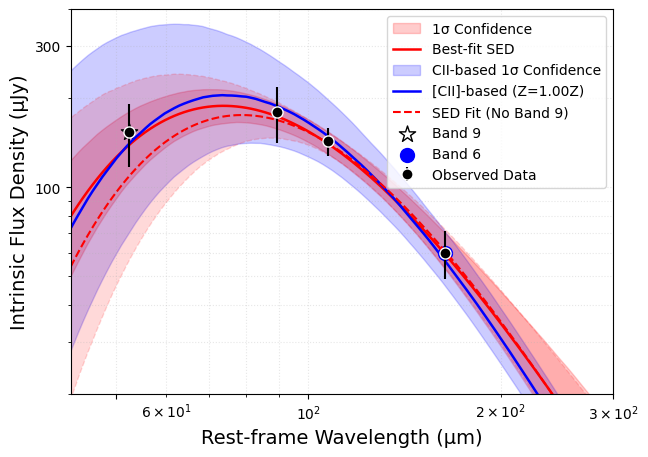

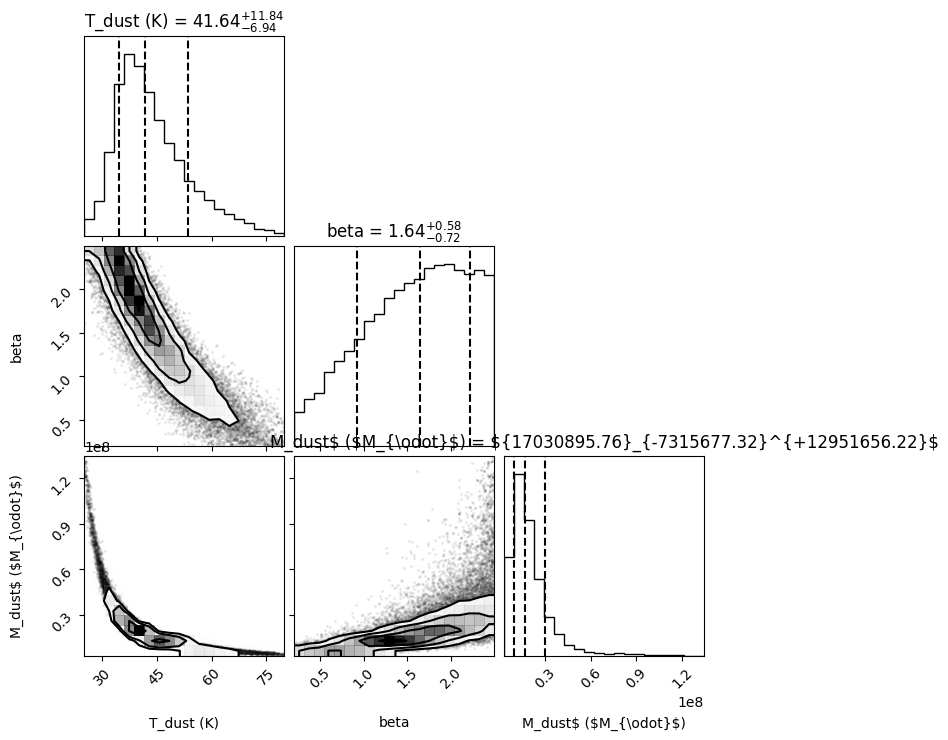

Mean acceptance fraction: 0.435


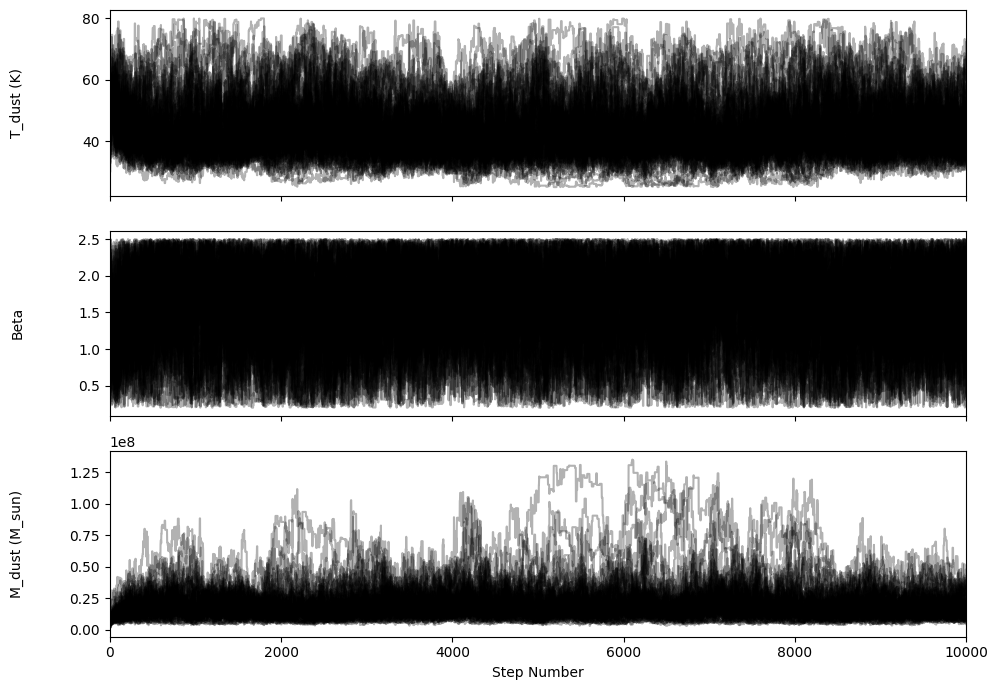

In [ ]:
# ================================
# SED Fit Without Band 9 (Red Dashed Line)
# ================================

# Exclude Band 9 data
wavelength_obs_noB9 = wavelength_obs[1:]  # Remove Band 9 (first index)

freq_obs_noB9 = freq_obs[1:]
freq_plot_noB9 = np.logspace(np.log10(min(freq_obs_noB9)) - 0.5, np.log10(max(freq_obs_noB9)) + 0.5, 200)
wavelength_plot_noB9 = (const.c.to(u.um / u.s).value / freq_plot_noB9) / (1 + z)
flux_obs_noB9 = flux_obs[1:]
flux_err_noB9 = flux_err[1:]

# Run MCMC again for the new dataset
sampler_noB9 = emcee.EnsembleSampler(n_walkers, 3, log_probability,
                                     args=(freq_obs_noB9, flux_obs_noB9.value, flux_err_noB9.value, z))
print("Running MCMC without Band 9...")
sampler_noB9.run_mcmc(pos, n_steps, progress=True)
print("MCMC without Band 9 complete!")

# Extract MCMC results (no Band 9)
flat_samples_noB9 = sampler_noB9.get_chain(discard=2000, thin=15, flat=True)
T_dust_mcmc_noB9, beta_mcmc_noB9, M_dust_mcmc_noB9 = np.median(flat_samples_noB9, axis=0)

# Compute confidence intervals
T_dust_err_noB9 = np.percentile(flat_samples_noB9[:, 0], [16, 84])
beta_err_noB9 = np.percentile(flat_samples_noB9[:, 1], [16, 84])
M_dust_err_corr_noB9 = np.percentile(flat_samples_noB9[:, 2], [16, 84]) / magnification_factor
M_dust_mcmc_corr_noB9 = M_dust_mcmc_noB9 / magnification_factor

# Apply CMB correction to SED-derived temperature
T_dust_mcmc_noB9_corrected = T_dust_mcmc_noB9
# Print results for comparison
print("MCMC Results Without Band 9:")
print(f"T_dust (no B9) = {T_dust_mcmc_noB9_corrected:.2f} (+{T_dust_err_noB9[1] - T_dust_mcmc_noB9:.2f}, -{T_dust_mcmc_noB9 - T_dust_err_noB9[0]:.2f}) K")
print(f"Beta (no B9) = {beta_mcmc_noB9:.2f} (+{beta_err_noB9[1] - beta_mcmc_noB9:.2f}, -{beta_mcmc_noB9 - beta_err_noB9[0]:.2f})")
print(f"M_dust (no B9) = {M_dust_mcmc_corr_noB9:.2e} (+{M_dust_err_corr_noB9[1] - M_dust_mcmc_noB9:.2e}, -{M_dust_mcmc_noB9 - M_dust_err_corr_noB9[0]:.2e}) M_sun")

# Compute the SED fit without Band 9
model_flux_plot_noB9 = observed_flux(freq_plot, T_dust_mcmc_noB9_corrected, beta_mcmc_noB9, M_dust_mcmc_noB9, D_L) * 1e6

# Compute confidence intervals
random_samples_noB9 = flat_samples_noB9[np.random.randint(len(flat_samples_noB9), size=n_samples)]
flux_samples_noB9 = np.array([observed_flux(freq_plot, s[0], s[1], s[2], D_L) * 1e6 for s in random_samples_noB9])
flux_lower_noB9, flux_upper_noB9 = np.percentile(flux_samples_noB9, [16, 84], axis=0)

fig, ax = plt.subplots(figsize=(7, 5))

# Plot the SED (red line with confidence interval)
ax.fill_between(wavelength_plot, flux_lower, flux_upper, color="red", alpha=0.2, label="1σ Confidence")
ax.plot(wavelength_plot, model_flux_plot, 'r-', linewidth=1.8, label="Best-fit SED")

# Compute 16th and 84th percentile flux values (1σ confidence interval)
flux_SED_lower_noB9, flux_SED_upper_noB9 = np.percentile(flux_samples_noB9, [16, 84], axis=0)

# Plot Confidence Interval
#flux_CII_uJy_median = np.array([observed_flux(nu, Td_median_corrected, beta_CII, Md_median, D_L) for nu in freq_plot])
flux_CII_median = np.median(flux_CII_samples, axis=0)
ax.fill_between(wavelength_plot, flux_CII_lower, flux_CII_upper, color="blue", alpha=0.2, label="CII-based 1σ Confidence")
ax.plot(wavelength_plot, flux_CII_median, 'b-', linewidth=1.8, label=f"[CII]-based (Z={Z_fid:.2f}Z)")

# Confidence Interval for No Band 9 SED Fit - Dashed Red Shaded
plt.fill_between(wavelength_plot, flux_SED_lower_noB9, flux_SED_upper_noB9, color='red', alpha=0.15, linestyle='dashed')
plt.plot(wavelength_plot, model_flux_plot_noB9, 'r--', label="SED Fit (No Band 9)")

# Observed data points
ax.errorbar(wavelength_rest.to(u.micron).value, flux_obs.value * 1e6, yerr=flux_err.value * 1e6, 
            fmt='o', color='black', markersize=8, markeredgecolor='white', label="Observed Data")

# Star marker for Band 9
ax.scatter(wavelength_rest[0].to(u.micron).value, flux_obs[0].value * 1e6, color='white', marker='*', s=150, edgecolor='black', label="Band 9")

# Blue dot for Band 6
ax.scatter(wavelength_rest[3].to(u.micron).value, flux_obs[3].value * 1e6, 
           color='blue', marker='o', s=100, edgecolor='blue', label="Band 6")

# Formatting
# Define labels for the parameters
labels = [r"T_dust (K)", r"beta", r"M_dust$ ($M_{\odot}$)"]

# Create the corner plot
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt=".2f")

ax.set_xlabel("Rest-frame Wavelength (µm)", fontsize=14)
ax.set_ylabel("Intrinsic Flux Density (µJy)", fontsize=14)
ax.set_xscale('log')
ax.set_xlim(np.min(wavelength_rest.to(u.micron).value)-10,  np.max(wavelength_rest.to(u.micron).value)+10)  
ax.set_yscale('log')

ax.set_yticks([1, 10, 100, 300])  
ax.set_xticks([50, 100, 300]) 
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}"))

ax.set_ylim(20, 400) 

ax.legend()
ax.grid(True, which="both", linestyle=":", alpha=0.3)

plt.show()
 
 # Plotting the trace plots for convergence visualization
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ["T_dust (K)", "Beta", "M_dust (M_sun)"]
samples = sampler.get_chain()

# Check how well the sampler is performing
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)  # Plot all walkers
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step Number")
plt.tight_layout()
plt.show()